In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os, sys
import scipy.ndimage
import pickle
from multiprocessing import Pool
from skimage import measure, morphology
import random
import pylab
import skimage.transform

#parameters
np.random.seed(314159)
random.seed(314159)
DATA_PATH = '/media/sohn/Storage/mdata/CBIS-DDSM/'
path_lab = '/media/sohn/Storage/mdata/'
#OUTPUT_FOLDER = '/mnt/data/ndsb17/unpacked/processed/'

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow, figure, hist, plot, scatter, colorbar
%matplotlib inline


In [3]:
#Loading Data
def get_file_names(path):
    x=[]
    for root, dirs, files in os.walk(path, topdown=False):
        for name in files:
            x.append(os.path.join(root, name))
    return x

In [4]:
file_names = get_file_names(DATA_PATH)

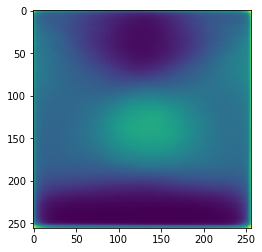

In [37]:
imshow(np.mean(X, axis=0))

In [20]:
d = load_dicom(file_names[0])

image = d.pixel_array

In [27]:
image[...,None].shape

(5056, 2761, 1)

In [30]:
image_small = skimage.transform.resize(image, (256,256), preserve_range=True)

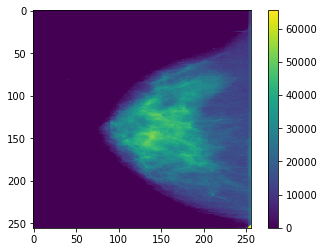

In [31]:
imshow(image_small)
colorbar()

In [5]:
df = pd.read_csv(DATA_PATH + '../mass_case_description_train_set.csv')

In [39]:
df

,patient_id,breast_density,side,view,abn_num,mass_shape,mass_margins,assessment,pathology,subtlety,od_img_path,od_crop_path,mask_path
0,P_00001,3,LEFT,CC,1,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass_Training_full_mammogram_images.jnlp,Mass-Training_ROI-mask_and_crpped_images.jnlp,Mass-Training_ROI-mask_and_crpped_images.jnlp
1,P_00001,3,LEFT,MLO,1,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass_Training_full_mammogram_images.jnlp,Mass-Training_ROI-mask_and_crpped_images.jnlp,Mass-Training_ROI-mask_and_crpped_images.jnlp
2,P_00004,3,LEFT,CC,1,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass_Training_full_mammogram_images.jnlp,Mass-Training_ROI-mask_and_crpped_images.jnlp,Mass-Training_ROI-mask_and_crpped_images.jnlp
3,P_00004,3,LEFT,MLO,1,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass_Training_full_mammogram_images.jnlp,Mass-Training_ROI-mask_and_crpped_images.jnlp,Mass-Training_ROI-mask_and_crpped_images.jnlp
4,P_00004,3,RIGHT,MLO,1,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass_Training_full_mammogram_images.jnlp,Mass-Training_ROI-mask_and_crpped_images.jnlp,Mass-Training_ROI-mask_and_crpped_images.jnlp
5,P_00009,3,RIGHT,CC,1,OVAL,ILL_DEFINED,4,MALIGNANT,4,Mass_Training_full_mammogram_images.jnlp,Mass-Training_ROI-mask_and_crpped_images.jnlp,Mass-Training_ROI-mask_and_crpped_images.jnlp
6,P_00009,3,RIGHT,MLO,1,OVAL,ILL_DEFINED,4,MALIGNANT,4,Mass_Training_full_mammogram_images.jnlp,Mass-Training_ROI-mask_and_crpped_images.jnlp,Mass-Training_ROI-mask_and_crpped_images.jnlp
7,P_00015,3,LEFT,MLO,1,IRREGULAR,ILL_DEFINED-SPICULATED,4,MALIGNANT,4,Mass_Training_full_mammogram_images.jnlp,Mass-Training_ROI-mask_and_crpped_images.jnlp,Mass-Training_ROI-mask_and_crpped_images.jnlp
8,P_00018,2,RIGHT,CC,1,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass_Training_full_mammogram_images.jnlp,Mass-Training_ROI-mask_and_crpped_images.jnlp,Mass-Training_ROI-mask_and_crpped_images.jnlp
9,P_00018,2,RIGHT,MLO,1,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass_Training_full_mammogram_images.jnlp,Mass-Training_ROI-mask_and_crpped_images.jnlp,Mass-Training_ROI-mask_and_crpped_images.jnlp


In [40]:
df2 = pd.read_csv(DATA_PATH + '../calc_case_description_train_set.csv')

In [41]:
df2

,patient_id,breast_density,side,view,abn_num,calc_type,calc_distribution,assessment,pathology,subtlety,od_img_path,od_crop_path,mask_path
0,P_00005,3,RIGHT,CC,1,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc_Training_full_mammogram_images.jnlp,Calc-Training_ROI-mask_and_crpped_images.jnlp,Calc-Training_ROI-mask_and_crpped_images.jnlp
1,P_00005,3,RIGHT,MLO,1,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc_Training_full_mammogram_images.jnlp,Calc-Training_ROI-mask_and_crpped_images.jnlp,Calc-Training_ROI-mask_and_crpped_images.jnlp
2,P_00007,4,LEFT,CC,1,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc_Training_full_mammogram_images.jnlp,Calc-Training_ROI-mask_and_crpped_images.jnlp,Calc-Training_ROI-mask_and_crpped_images.jnlp
3,P_00007,4,LEFT,MLO,1,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc_Training_full_mammogram_images.jnlp,Calc-Training_ROI-mask_and_crpped_images.jnlp,Calc-Training_ROI-mask_and_crpped_images.jnlp
4,P_00008,1,LEFT,CC,1,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,Calc_Training_full_mammogram_images.jnlp,Calc-Training_ROI-mask_and_crpped_images.jnlp,Calc-Training_ROI-mask_and_crpped_images.jnlp
5,P_00008,1,LEFT,CC,2,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,Calc_Training_full_mammogram_images.jnlp,Calc-Training_ROI-mask_and_crpped_images.jnlp,Calc-Training_ROI-mask_and_crpped_images.jnlp
6,P_00008,1,LEFT,CC,3,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,Calc_Training_full_mammogram_images.jnlp,Calc-Training_ROI-mask_and_crpped_images.jnlp,Calc-Training_ROI-mask_and_crpped_images.jnlp
7,P_00008,1,LEFT,MLO,1,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,Calc_Training_full_mammogram_images.jnlp,Calc-Training_ROI-mask_and_crpped_images.jnlp,Calc-Training_ROI-mask_and_crpped_images.jnlp
8,P_00008,1,LEFT,MLO,2,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,Calc_Training_full_mammogram_images.jnlp,Calc-Training_ROI-mask_and_crpped_images.jnlp,Calc-Training_ROI-mask_and_crpped_images.jnlp
9,P_00008,1,LEFT,MLO,3,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,Calc_Training_full_mammogram_images.jnlp,Calc-Training_ROI-mask_and_crpped_images.jnlp,Calc-Training_ROI-mask_and_crpped_images.jnlp


In [6]:
df["file_name"] = [ None for x in range(len(df)) ]
for n in range(len(df)):
    key = df["patient_id"][n] +'_'+ df["side"][n] +'_'+ df["view"][n]
    for fn in file_names:
        if key in fn:
            df.loc[n, "file_name"] = fn
            break

In [7]:
for n in range(len(df)):
    if  df.loc[n, "file_name"] is None:
        print(n)

In [8]:
file_names = list(df["file_name"])

In [9]:
breast_density = list(df["breast_density"])

In [ ]:
file_names = file_names[:733] + file_names[734:]
# TODO same for density

In [10]:

images = []
for fn in file_names:
    d = dicom.read_file(fn)
    image = d.pixel_array
    image_small = skimage.transform.resize(image, (224,224), preserve_range=True)
    images.append(image_small)


ValueError: cannot reshape array of size 16388372 into shape (5251,3121)

In [11]:
X = np.stack(images)[...,None]

In [12]:
X = np.repeat(X, 3, axis=-1)

In [13]:
X.shape

(732, 224, 224, 3)

In [14]:
X = (X - np.mean(X)) / np.std(X)

In [16]:
len(breast_density)

1318

In [17]:
y = np.asarray(breast_density)-1

In [18]:
y = y[ :X.shape[0] ]

In [33]:
np.save('mdata_X.npy', X)
np.save('mdata_y.npy', y)

In [3]:
X = np.load('mdata_X.npy')
y = np.load('mdata_y.npy')

In [4]:
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


In [5]:
model = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [7]:
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Conv2D, Dense, Flatten

In [8]:
x = model.layers[-1].output
x = Flatten()(x)
x = Dense(512, init='orthogonal', activation='relu')(x)
x = Dense(4, init='orthogonal', activation='softmax')(x)

model2 = Model(model.inputs, x)
print(model2.summary())


/home/sohn/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_initializer="orthogonal")`
  app.launch_new_instance()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

/home/sohn/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="softmax", kernel_initializer="orthogonal")`


In [9]:
from keras.optimizers import SGD, Adam, Nadam, RMSprop
optimizer = Adam(lr=0.0001)

#model2.compile(loss='squared_hinge', metrics=['accuracy'], optimizer=optimizer)
model2.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

In [10]:
from keras_tqdm import TQDMNotebookCallback

In [11]:
model2.fit(
    X, 
    y, 
    batch_size=64,
    epochs=10,
    validation_split=0.2,
    verbose=0, 
    callbacks=[TQDMNotebookCallback(leave_inner=True)])

In [12]:
y_pred = model2.predict(X)

In [14]:
list(zip(y, y_pred))

[(2, array([  7.11654707e-07,   3.84683907e-02,   9.40560520e-01,
           2.09703017e-02], dtype=float32)),
 (2, array([  4.99158148e-07,   1.44546917e-02,   9.85537887e-01,
           6.91227979e-06], dtype=float32)),
 (2, array([  2.03553174e-09,   2.70961232e-06,   9.99980569e-01,
           1.67062353e-05], dtype=float32)),
 (2, array([  2.48531904e-07,   3.41908571e-06,   9.99990821e-01,
           5.53330892e-06], dtype=float32)),
 (2, array([  3.99089458e-06,   6.29186572e-04,   9.99190271e-01,
           1.76512505e-04], dtype=float32)),
 (2, array([  4.40816876e-08,   2.01163162e-02,   9.73628402e-01,
           6.25520386e-03], dtype=float32)),
 (2, array([  6.21309511e-08,   2.68697049e-02,   9.72632587e-01,
           4.97683766e-04], dtype=float32)),
 (2, array([  6.25730223e-08,   6.61378652e-02,   9.32762027e-01,
           1.10002107e-03], dtype=float32)),
 (1, array([  1.21120289e-02,   9.82089162e-01,   5.75748086e-03,
           4.13261041e-05], dtype=float32)),
 

In [15]:
from sklearn.metrics import confusion_matrix

In [18]:
y_pred_assigned = [ np.argmax(y_pred[n]) for n in range(len(y_pred)) ]

In [39]:
cm = confusion_matrix(y, y_pred_assigned)
cm

array([[148,  18,   2,   0],
       [ 11, 289,   6,   3],
       [  1,  50, 138,   5],
       [  0,   7,   2,  52]])

In [42]:
cm = confusion_matrix(y[-len(y)//5:], y_pred_assigned[-len(y)//5:])
cm

array([[19, 13,  0,  0],
       [11, 36,  6,  3],
       [ 1, 37,  9,  4],
       [ 0,  5,  1,  2]])

In [43]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          do_cell_labels=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm / np.amax(cm), interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    if do_cell_labels:
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Normalized confusion matrix
[[ 0.59375     0.40625     0.          0.        ]
 [ 0.19642857  0.64285714  0.10714286  0.05357143]
 [ 0.01960784  0.7254902   0.17647059  0.07843137]
 [ 0.          0.625       0.125       0.25      ]]


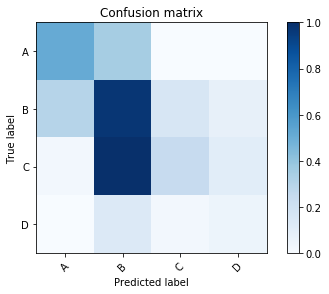

In [44]:
plot_confusion_matrix(cm, ['A', 'B', 'C', 'D'], normalize=True)